In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


In [ ]:
import pandas as pd
import folium
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors



from shapely.geometry import MultiPoint, mapping
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_excel("./data/subway_location.xlsx", sheet_name="subway(seoul_mat)")
df = df[["역사명", "노선명", "latitude", "longitude"]]
df = df[df["역사명"] != "양원역"] # 좌표 위치 경기도 외부로 확인

In [ ]:
# 지하철 노선 별 지도 시각화

line_names = df["노선명"].unique()

colors = plt.cm.tab20.colors
color_map = {
    line: f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}"
    for line, (r, g, b, _) in zip(line_names, plt.cm.tab20(range(len(line_names))))
}

def closest_color_name(rgb_tuple):
    min_dist = float("inf")
    closest_name = None
    for name, hex in mcolors.CSS4_COLORS.items():
        r2, g2, b2 = mcolors.to_rgb(hex)
        dist = (rgb_tuple[0] - r2)**2 + (rgb_tuple[1] - g2)**2 + (rgb_tuple[2] - b2)**2
        if dist < min_dist:
            min_dist = dist
            closest_name = name
    return closest_name

rgb_colors = [color[:3] for color in plt.cm.tab20.colors]
color_name_map = {
    line: closest_color_name(rgb)
    for line, rgb in zip(line_names, rgb_colors)
}

m = folium.Map(location=[37.566734, 126.978123], zoom_start=7.5)

for i in range(df.shape[0]):
    line_name = df.iloc[i]["노선명"]
    folium.CircleMarker(
        location=[df.iloc[i]['latitude'], df.iloc[i]['longitude']],
        radius=4,
        color=color_map[line_name],
        fill=True,
        fill_color=color_map[line_name],
        fill_opacity=0.7,
        popup=f"<strong>역사명 :</strong> {df.iloc[i]['역사명']}<br>"
        f"<strong>노선명 :</strong> {df.iloc[i]['노선명']}",  max_width=300, min_width=200
    ).add_to(m)

m

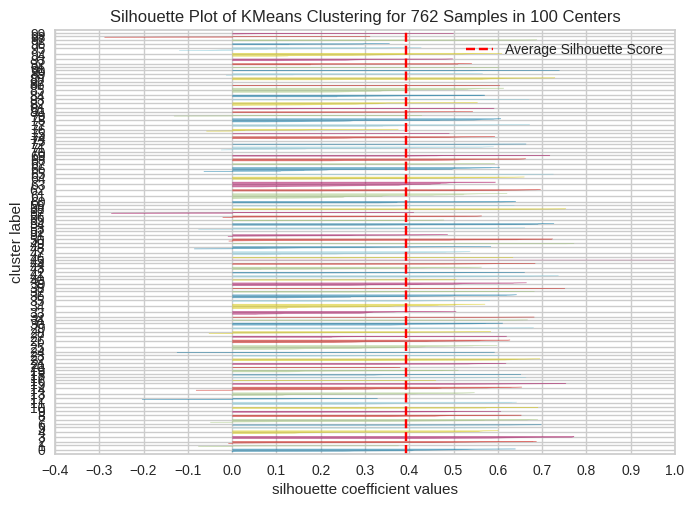

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 762 Samples in 100 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
kmeans= KMeans(n_clusters=100, max_iter=1000, random_state=123)
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

visualizer.fit(df[["latitude", "longitude"]])
visualizer.show() # 실루엣 스코어 확인

In [ ]:
model = KMeans(n_clusters=100, max_iter=1000, random_state=123)
label = model.fit_predict(df[["latitude", "longitude"]])
centers = model.cluster_centers_
df["cluster"] = label

cmap = plt.cm.get_cmap('hsv', 100)
colors = [mcolors.rgb2hex(cmap(i)) for i in range(100)]

seoul = folium.Map(location=[37.566734, 126.978123], zoom_start=7.5)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color=colors[row['cluster']],
        fill=True,
        fill_opacity=0.7
    ).add_to(seoul)

for i, (lat, lon) in enumerate(centers):
    folium.Marker(
        location=[lat, lon],
         icon=folium.DivIcon(html=f"""
            <div style="
                font-size:20px;
                color:{colors[i]};
                font-weight:bold;
                line-height:40px;
            ">
                ★
            </div>
        """),
        popup=f'Center {i}'
    ).add_to(seoul)

for cluster_id in range(100):
    pts = df[df['cluster'] == cluster_id][['longitude','latitude']].values
    if len(pts) >= 3:
        hull = MultiPoint(pts).convex_hull
        folium.GeoJson(
            mapping(hull),
            style_function=lambda feature, cid=cluster_id: {
                'fillColor': colors[cid],
                'color': colors[cid],
                'weight': 1,
                'fillOpacity': 0.1
            }
        ).add_to(seoul)

In [ ]:
seoul